## Code for reading the HAR-UML dataset

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from source.read_HAR_dataset import read_har_dataset, har_dimensions
from source.utils import create_dir
import os

# Shuffle all data from all participants (SHOULD BE ONLY USED TO FIND THE BEST MODEL)
SHUFFLE_ALL = True
LOSS = "SupConLoss" # "Contrastive" or "Triplet"  or "SupConLoss" or "SimCLR"
SUBSEC_PORC = 0.75 # Porcentage of the window to be used as a sub-sequence
FEAT_DIM = 128 # Dimension of the code of input to the LOSS criterion (IS NOT THE FEATERURE DIMENSION!!)
EPOCHS   = 200 # You know ...
EXP_DIR = 'experiments'

mode = 'shuffle' if SHUFFLE_ALL else 'noshuffle'

EXPERIMENT_NAME = 'Exp_{}_{}_{}_{}'.format(LOSS, mode, FEAT_DIM, int(SUBSEC_PORC * 100), EPOCHS)
EXP_PATH = os.path.join(EXP_DIR, EXPERIMENT_NAME)
create_dir(EXP_DIR)
create_dir(EXP_PATH)

activities = [
    "Sitting",
    "Lying",
    "Standing",
    "Walking",
    "Running",
    "Downstairs",
    "Upstairs"
]


/home/texs/anaconda3/envs/contrastive/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/texs/anaconda3/envs/contrastive/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
%autoreload 2

data = read_har_dataset('./datasets/HAR-UML20/')

ids_train, X_train, y_train, I_train, train_kcal_MET = data['train']

ids_val, X_val, y_val, I_val, val_kcal_MET = data['val']

ids_test, X_test, y_test, I_test, test_kcal_MET = data['test']

IDS: [4, 3, 0, 2, 7, 5, 8, 6, 9, 1]
Train IDS: [4, 3, 0, 2, 7, 5]
Test IDS: [8, 6]
Val IDS: [9, 1]


In [3]:
def shuffle_data(train_list, test_list, val_list, shuffled_indices):
    X = np.concatenate([train_list, test_list, val_list], axis=0)
    X = np.array([X[i] for i in shuffled_indices])
    n_tr = len(train_list)
    n_te = len(test_list)
    n_val = len(val_list)
    return X[0: n_tr], X[n_tr: n_tr + n_te], X[n_tr + n_te:]

if SHUFFLE_ALL:
    n = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]
    ids = list(range(n))
    shuffled_indices = np.random.permutation(len(ids))

    X_train, X_test, X_val = shuffle_data(X_train, X_test, X_val, shuffled_indices)
    y_train, y_test, y_val = shuffle_data(y_train, y_test, y_val, shuffled_indices)
    I_train, I_test, I_val = shuffle_data(I_train, I_test, I_val, shuffled_indices)
    train_kcal_MET, test_kcal_MET, val_kcal_MET = shuffle_data(train_kcal_MET, test_kcal_MET, val_kcal_MET, shuffled_indices)

In [4]:
har_dimensions

array(['Accelerometer-X', 'Accelerometer-Y', 'Accelerometer-Z',
       'Gyrometer-X', 'Gyrometer-Y', 'Gyrometer-Z', 'Magnetometer-X',
       'Magnetometer-Y', 'Magnetometer-Z'], dtype='<U15')

In [5]:
from source.utils import  filter_dimensions
dimensions = ['Accelerometer-X', 'Accelerometer-Y', 'Accelerometer-Z', 'Gyrometer-X', 'Gyrometer-Y', 'Gyrometer-Z']

X_train_f = filter_dimensions(X_train, har_dimensions, dimensions)
X_test_f = filter_dimensions(X_test, har_dimensions, dimensions)
X_val_f = filter_dimensions(X_val, har_dimensions, dimensions)

In [6]:
from source.datasets import ContrastiveDataset
from torch.utils.data import DataLoader

train_dataset = ContrastiveDataset(X_train_f.transpose([0, 2, 1]).astype(np.float32), y_train, use_label=False)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = ContrastiveDataset(X_val_f.transpose([0, 2, 1]).astype(np.float32), y_val, use_label=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataset = ContrastiveDataset(X_test_f.transpose([0, 2, 1]).astype(np.float32), y_test, use_label=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [7]:
from source.utils import getViews

kl_max = 0.0005
kl_min = 0.00001

def KL_Loss(z_mu, z_var):
    # recon_loss = F.mse_loss(X_sample, X, reduction='sum') / mb_size
    kl_loss = torch.mean(
        0.5 * torch.sum(torch.exp(z_var) + z_mu ** 2 - 1. - z_var, 1))
    return kl_loss

def train_batch(model, data, optimizer, criterion, device, win_len, curr_epoch, n_epochs, supervised= True):
    model.features.train()
    model.linear.train()
    
    optimizer.zero_grad()
    xA, xB, lA, lB = data # Shape BxDxT

    view1, view2, view3, view4 = getViews(xA, win_len)

    B, D, T = xA.shape

    view1 = view1.to(device)
    view2 = view2.to(device)
    view3 = view3.to(device)
    view4 = view4.to(device)
    
    codes1, z_mu1, z_var1 = model(view1)
    codes2, z_mu2, z_var2 = model(view2)
    codes3, z_mu3, z_var3 = model(view3)
    codes4, z_mu4, z_var4 = model(view4)
    
    viewsCodes = torch.stack([codes1, codes2, codes3, codes4], 1)
    
    kl_loss = KL_Loss(z_mu1, z_var1) + KL_Loss(z_mu2, z_var2) + KL_Loss(z_mu3, z_var3) + KL_Loss(z_mu4, z_var4) 
    kl_loss = kl_loss * (kl_min + (kl_max - kl_min)  * (curr_epoch/n_epochs))
    
    if supervised:
        loss = criterion(viewsCodes, lA) + kl_loss
    else:
        loss = criterion(viewsCodes) + kl_loss

    loss.backward()
    optimizer.step()
    return loss.item(), kl_loss.item()
    

def eval_batch(model, data, criterion, device, win_len, curr_epoch, n_epochs, supervised= True):
    model.features.eval()
    model.linear.eval()
    
    xA, xB, lA, lB = data

    view1, view2, view3, view4 = getViews(xA, win_len)
    
    view1 = view1.to(device)
    view2 = view2.to(device)
    view3 = view3.to(device)
    view4 = view4.to(device)
    
    codes1, z_mu1, z_var1 = model(view1)
    codes2, z_mu2, z_var2 = model(view2)
    codes3, z_mu3, z_var3 = model(view3)
    codes4, z_mu4, z_var4 = model(view4)

    B, D, T = xA.shape
    
    viewsCodes = torch.stack([codes1, codes2, codes3, codes4], 1)
    
    kl_loss = KL_Loss(z_mu1, z_var1) + KL_Loss(z_mu2, z_var2) + KL_Loss(z_mu3, z_var3) + KL_Loss(z_mu4, z_var4) 
    kl_loss = kl_loss * (kl_min + (kl_max - kl_min)  * (curr_epoch/n_epochs))
    
    if supervised:
        
        loss = criterion(viewsCodes, lA) + kl_loss 
    else:
        loss = criterion(viewsCodes) + kl_loss 

    return loss.item(), kl_loss.item()



Subsequence length: 150
Epoch[1] Train loss    avg: 4.831981354986715
Epoch[1] Train KL loss    avg: 0.007953255750478535
Epoch[1] Val Kl loss    avg: 0.012495388830396926
Epoch[1] Val loss      avg: 4.365952847138891
[Log] Saving model with loss: 4.365952847138891
[Log] Saving model with loss: 3.8488582485127
[Log] Saving model with loss: 3.5873296710680114
[Log] Saving model with loss: 3.5024416401701153
[Log] Saving model with loss: 3.4613473370390118
[Log] Saving model with loss: 3.3998602291323103
[Log] Saving model with loss: 3.361266181154071
[Log] Saving model with loss: 3.333493417164065
Epoch[10] Train loss    avg: 3.3486009480660424
Epoch[10] Train KL loss    avg: 0.031142082185163136
Epoch[10] Val Kl loss    avg: 0.0322943860840685
Epoch[10] Val loss      avg: 3.3651981308775127
[Log] Saving model with loss: 3.3141827223435887
[Log] Saving model with loss: 3.313449589711315
[Log] Saving model with loss: 3.309673601726316
[Log] Saving model with loss: 3.297391207713001
[Log]

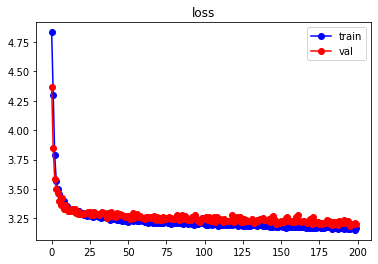

In [8]:
%autoreload 2
from torch_snippets import *
from source.models import VAESiameseNetwork
from source.losses import ContrastiveLoss, SupConLoss, TripletLoss
from source.utils import ValueLogger
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'



subsequence_length = int(X_train_f.shape[1] * SUBSEC_PORC)

print("Subsequence length: {}".format(subsequence_length))

model      = VAESiameseNetwork(X_train_f.shape[2], subsequence_length, device, feat_dim=FEAT_DIM).to(device)

model_path = os.path.join(EXP_PATH, 'model.pt')
loss_path = os.path.join(EXP_PATH, 'loss.png')

if LOSS == "Contrastive":
    criterion  = ContrastiveLoss().to(device)
elif LOSS == "Triplet":
    criterion  = TripletLoss(margin=4.0).to(device)
elif LOSS == "SupConLoss":
    criterion = SupConLoss().to(device)
    supervised = True
else:
    criterion = SupConLoss().to(device)
    supervised = False

trainLogs = ValueLogger("Train loss   ", epoch_freq=10)
trainKlLogs = ValueLogger("Train KL loss   ", epoch_freq=10)
testLogs = ValueLogger( "Test loss    ", epoch_freq=10)
testKlLogs = ValueLogger("Test KL loss   ", epoch_freq=10)
valLogs = ValueLogger(  "Val loss     ", epoch_freq=10)
valKlLogs = ValueLogger("Val Kl loss   ", epoch_freq=10)

# optimizer  = optim.AdamW(model.parameters(),lr = 0.0005, )
# optimizer  = optim.AdamW(model.parameters(),lr = 0.00001) #Triplet
# optimizer  = optim.SGD(model.parameters(),lr = 0.001)
optimizer  = optim.Adam(model.parameters(),lr = 0.0005, weight_decay=0)

for epoch in range(EPOCHS):
    N = len(train_dataloader)
    for i, data in enumerate(train_dataloader):
        loss = None
        if LOSS == "Contrastive":
            loss = train_batch_contrastive(model, data, optimizer, criterion, device, subsequence_length)
        elif LOSS == "Triplet":
            loss = train_batch_triplet(model, data, optimizer, criterion, device, subsequence_length)
        elif LOSS == "SupConLoss":
            loss, kl_loss = train_batch(model, data, optimizer, criterion, device, subsequence_length, epoch, EPOCHS, supervised=supervised)
        else:
            loss, kl_loss = train_batch(model, data, optimizer, criterion, device, subsequence_length, epoch, EPOCHS, supervised=supervised)
        trainLogs.update(loss)
        trainKlLogs.update(kl_loss)
    trainLogs.end_epoch()
    trainKlLogs.end_epoch()
    with torch.no_grad():
        N = len(val_dataloader)
        for i, data in enumerate(val_dataloader):
            if LOSS == "Contrastive":
                loss = eval_batch_contrastive(model, data,  criterion, device, subsequence_length)
            elif LOSS == "Triplet":
                loss = eval_batch_triplet(model, data,  criterion, device, subsequence_length)
            elif LOSS == "SupConLoss":
                loss, kl_loss = eval_batch(model, data,  criterion, device, subsequence_length, epoch, EPOCHS, supervised=supervised)
            else:
                loss, kl_loss = eval_batch(model, data,  criterion, device, subsequence_length, epoch, EPOCHS, supervised=supervised)
            valLogs.update(loss)
            valKlLogs.update(kl_loss)
        
        valKlLogs.end_epoch()    
        if  valLogs.end_epoch():
            print('[Log] Saving model with loss: {}'.format(valLogs.bestAvg))
            torch.save(model, model_path) 

fig = plt.figure()
ax0 = fig.add_subplot(111, title="loss")
ax0.plot(trainLogs.avgs, 'bo-', label='train')
ax0.plot(valLogs.avgs, 'ro-', label='val')

ax0.legend()
fig.savefig(loss_path)

In [9]:
  
# model = torch.load(model_path)
with torch.no_grad():
    N = len(test_dataloader)
    for i, data in enumerate(test_dataloader):
        if LOSS == "Contrastive":
            if LOSS == "Contrastive":
                loss = eval_batch_contrastive(model, data, criterion, device, subsequence_length)
            elif LOSS == "Triplet":
                loss = eval_batch_triplet(model, data, criterion, device, subsequence_length)
            elif LOSS == "SupConLoss":
                loss = eval_batch(model, data, criterion, device, subsequence_length, supervised=supervised)
            else:
                loss = eval_batch(model, data, criterion, device, subsequence_length, supervised=supervised)
        testLogs.update(loss)
    testLogs.end_epoch()

Epoch[1] Test loss     avg: 2.6406636238098145


In [10]:
# # ---------------Load best model is you already saved it-----------------
# model      = SiameseNetwork(X_train_f.shape[2], win_len).to(device)
# model = torch.load(model_path)

In [11]:
# Get the representations from the model
train_repr = model.encode(X_train_f.transpose(0, 2, 1), device)
test_repr = model.encode(X_test_f.transpose(0, 2, 1), device)

In [12]:
train_repr.shape

(5460, 128)

## VISUALIZATION TASK

In [13]:
import umap
reducer = umap.UMAP(n_components = 2)
# reducer.fit(train_repr, y=y_train)
reducer.fit(train_repr)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [14]:
train_coords = reducer.transform(train_repr)
test_coords = reducer.transform(test_repr)

['Sitting', 'Lying', 'Standing', 'Walking', 'Running', 'Downstairs', 'Upstairs']


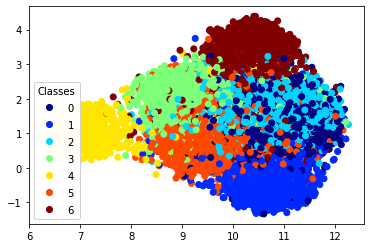

In [15]:
import matplotlib.pyplot as plt

print(activities)
fig, ax = plt.subplots()

scatter = ax.scatter(train_coords[:, 0], train_coords[:, 1], c = y_train, cmap='jet', label='Inline label')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)



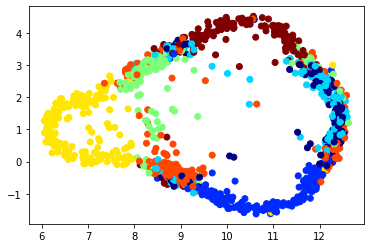

In [16]:
plt.scatter(test_coords[:, 0], test_coords[:, 1], c = y_test, cmap='jet')

## CLASSIFICATION TASK

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import svm

def classify_dataset(X_train, y_train, X_test, y_test):
    # clf = RandomForestClassifier(random_state=0)
    # clf = LinearSVC(dual=False, random_state=123)
    # clf = svm.SVC()
    clf = KNeighborsClassifier()
    clf.fit(X_train, y_train)
    return clf.predict(X_train), clf.predict(X_test)
    

train_pred, test_pred = classify_dataset(train_repr, y_train, test_repr, y_test)



/home/texs/anaconda3/envs/contrastive/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [18]:
from sklearn import metrics

bal_acc_tr = metrics.balanced_accuracy_score(y_train, train_pred)
bal_acc_te = metrics.balanced_accuracy_score(y_test, test_pred)

acc_tr = metrics.accuracy_score(y_train, train_pred)
acc_te = metrics.accuracy_score(y_test, test_pred)
            
f1_tr = metrics.f1_score(y_train, train_pred, average='weighted')
f1_te = metrics.f1_score(y_test, test_pred, average='weighted')

print("Training balanced accuracy: {} - testing balanced accuracy: {}".format(bal_acc_tr, bal_acc_te))
print("Training accuracy: {} - testing accuracy: {}".format(acc_tr, acc_te))
print("Training f1 score: {} - testing f1 score: {}".format(f1_tr, f1_te))

Training balanced accuracy: 0.8250998636725494 - testing balanced accuracy: 0.6804988122320221
Training accuracy: 0.8258241758241758 - testing accuracy: 0.6793650793650794
Training f1 score: 0.8295594928944375 - testing f1 score: 0.6932006096723035


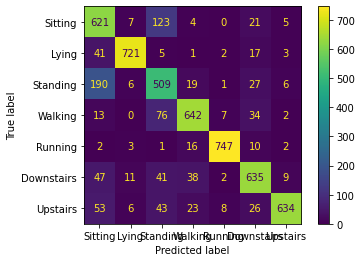

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_train = confusion_matrix(y_train, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels= activities)
disp.plot()


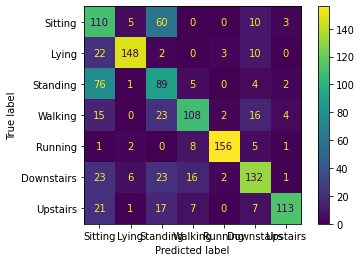

In [20]:
cm_test = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels= activities)
disp.plot()


## PREDICTION

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

def regression_results(y_true, y_pred):
    
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    # mse=metrics.mean_squared_error(y_true, y_pred) 
    # mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    # median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    
    
    # return round(mean_absolute_error,4), round(explained_variance,4)
    return round(mean_absolute_error,4), round(r2,4)

# regressor = LinearRegression()
regressor = SGDRegressor(loss="squared_error", penalty="l2", max_iter=20)
regressor.fit(train_repr, train_kcal_MET[:, 1])

/home/texs/anaconda3/envs/contrastive/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDRegressor(max_iter=20)

In [22]:
train_met_pred = regressor.predict(train_repr) 
test_met_pred = regressor.predict(test_repr) 
# regressor.score(train_repr, train_kcal_MET[:, 1])

In [23]:
print(regression_results(train_kcal_MET[:, 1], train_met_pred))
print(regression_results(test_kcal_MET[:, 1], test_met_pred))

(0.8886, 0.7568)
(0.9123, 0.7435)


In [24]:
test_met_pred[:10]

array([5.412, 4.62 , 0.89 , 0.962, 0.395, 0.303, 3.263, 0.767, 4.711,
       1.111])

In [25]:
test_kcal_MET[:10, 1]

array([6.743, 5.251, 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 6.434,
       1.   ], dtype=float32)